In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils.segmentation import create_segments
import pickle
import json

In [21]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

with open('../Handwritten-Equation-Solver/my_dict.json', 'r') as f:
    mapping = json.load(f)
print(mapping)

{'0': '0', '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': 'add', '11': 'cos', '12': 'div', '13': 'left_bracket', '14': 'left_curly_brace', '15': 'left_parenthesis', '16': 'log', '17': 'minus', '18': 'multiply', '19': 'right_bracket', '20': 'right_curly_brace', '21': 'right_parenthesis', '22': 'sin', '23': 'slash', '24': 'sqrt', '25': 'summation', '26': 'tan'}


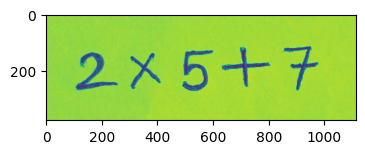

<Figure size 800x200 with 0 Axes>

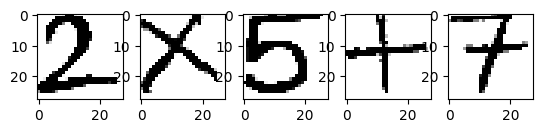

In [92]:
img = cv2.imread('../Handwritten-Equation-Solver/test_data/14.jpeg',cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(4,2))
plt.imshow(img)
plt.show()

segments = create_segments(img)
plt.figure(figsize=(8,2))

fig, axes = plt.subplots(1,len(segments))

for i in range(len(segments)):
    segments[i] = 255 - segments[i]
    axes[i].imshow(segments[i], cmap='gray')
plt.show()

In [93]:
class CharacterNet(nn.Module):

    ''' CNN architecture for character recognition '''

    def __init__(self):

        super(CharacterNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 27)


    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)

        return x
    
    
model = CharacterNet()
model.load_state_dict(torch.load('CharacterNet.pth'))

<All keys matched successfully>

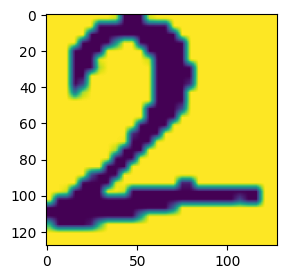

2


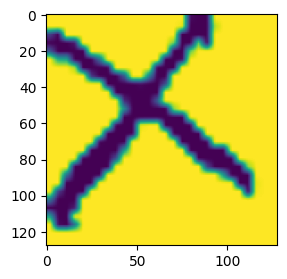

multiply


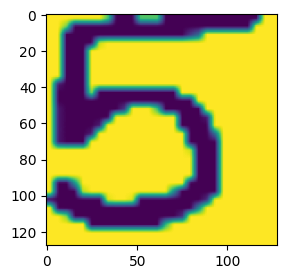

5


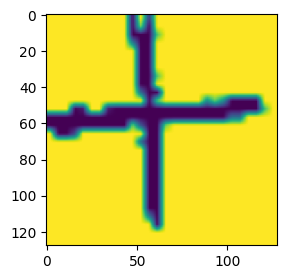

add


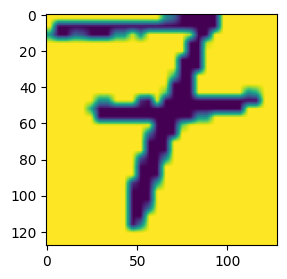

7


In [94]:
model = model.to(device)
equation = []

for img in segments:

    gray_image = cv2.resize(img, (128,128))
    gray_image = gray_image.reshape((1,128,128))
    data = torch.Tensor(np.array([gray_image])).to(device)
    output = model(data)
    _, predicted = torch.max(output.data, 1)
    plt.figure(figsize=(3,3))
    plt.imshow(gray_image[0])
    plt.show()
    index = predicted.cpu().numpy()[0]
    print(mapping[str(index)])

    equation.append(mapping[str(index)])

In [95]:
symbols = {'add':'+','minus':'-','div':'/', 'left_bracket':'[', 'left_curly_brace':'{', 'left_parenthesis':'(', 'log':'log', 'minus':'-', 'multiply':'*', 'right_bracket':']', 'right_curly_brace':'}', 'right_parenthesis':')', 'sin':'sin', 'slash':'/', 'sqrt':'sqrt', 'summation':'sum', 'tan':'tan'}

eqn = ""
for i in equation:
    if(len(i) > 1):
        eqn += symbols[i]
    else:
        eqn += i
print("Equation = ",eqn)
print("Answer = ",eval(eqn))

Equation =  2*5+7
Answer =  17
